<a href="https://colab.research.google.com/github/pulavartivinay/Face_Mask_Detection/blob/stream/streamModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# start

In [2]:
# installs

In [3]:
# imports
import tensorflow as tf
from keras.utils import plot_model
from keras.models import model_from_json
from keras import backend as K
import cv2
from google.colab.patches import cv2_imshow
import glob
import itertools
import numpy as np
import random
import matplotlib.pyplot as plt
import pickle

In [4]:
# loading dataset
# https://www.kaggle.com/ashishjangra27/face-mask-12k-images-dataset

!gdown --id 1NOzYPR3zAS8e2EFdRvjYpSBxg9RaDfxe #loading the dataset from google drive link to colab
!unzip /content/face-mask-12k.zip &> /dev/null #unzipping
!rm -rf /content/face-mask-12k.zip &> /dev/null #deleting the zip file
!rm -rf __MACOSX &> /dev/null

Downloading...
From: https://drive.google.com/uc?id=1NOzYPR3zAS8e2EFdRvjYpSBxg9RaDfxe
To: /content/face-mask-12k.zip
351MB [00:02, 125MB/s]


In [5]:
# hyper parameters
epochs = 10
batch_size = 32

In [6]:
# finding the perfect crop size, for whole dataset
# https://stackoverflow.com/questions/19098104/python-opencv2-cv2-wrapper-to-get-image-size

def generate_image_paths(dir_path):
  files_png = glob.glob(dir_path + '/**/*.png', recursive=True)
  paths = list(files_png)
  return paths

train_dataset_path = "/content/face-mask-12k/Train"
val_dataset_path = "/content/face-mask-12k/Validation"

train_paths = generate_image_paths(train_dataset_path)
val_paths = generate_image_paths(val_dataset_path)

print(len(train_paths)) #output: 10000
print(len(val_paths))   #output: 800

def find_avg_height_and_width(paths):
  sum_height = 0
  sum_width = 0
  for path in paths:
    image = cv2.imread(path)
    height, width, channels = image.shape
    sum_height += height
    sum_width += width
  avg_height = sum_height//len(paths)
  avg_width = sum_width//len(paths)
  return (avg_height, avg_width)

print("Train avg height and width", find_avg_height_and_width(train_paths)) #output: (153, 153)
print("Validation avg height and width", find_avg_height_and_width(val_paths)) #output: (152, 152)

10000
800
Train avg height and width (153, 153)
Validation avg height and width (152, 152)


In [7]:
# Preprocessing the data set into list of images
# https://keras.io/api/preprocessing/image/#image_dataset_from_directory-function

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/face-mask-12k/Train",
    labels="inferred",
    label_mode="binary",
    class_names=None,
    color_mode="rgb",
    batch_size=batch_size,
    image_size=(153, 153),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
)

val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/face-mask-12k/Validation",
    labels="inferred",
    label_mode="binary",
    class_names=None,
    color_mode="rgb",
    batch_size=batch_size,
    image_size=(153, 153),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
)

print("Train-dataset-length", len(train_dataset))
print("Validation-dataset-length", len(val_dataset))

Found 10000 files belonging to 2 classes.
Found 800 files belonging to 2 classes.
Train-dataset-length 313
Validation-dataset-length 25


In [8]:
# Stream Model 

class SModel:
  def __init__(self, input_shape):
    self.input_shape = input_shape
    self.model = self.get_model()
    self.train_history = []
    self.val_history = []
    self.test_history = []


  def get_model(self):
    inputs = tf.keras.Input(shape=self.input_shape)  #input layer
    base_model = tf.keras.applications.MobileNetV2(
                input_shape=self.input_shape,
                include_top=False, weights="imagenet", classes=2)(inputs)
    layer1 = tf.keras.layers.Conv2D(
        filters=2,
        kernel_size=4,
        strides=(1, 1),
        padding="valid",
        data_format=None,
        dilation_rate=(1, 1),
        groups=1,
        activation='relu',
        use_bias=True,
        kernel_initializer="glorot_uniform",
        bias_initializer="zeros",
        kernel_regularizer=None,
        bias_regularizer=None,
        activity_regularizer=None,
        kernel_constraint=None,
        bias_constraint=None,
    )(base_model)
    batch_normalization_layer1 = tf.keras.layers.BatchNormalization()(layer1)
    max_pool_2d = tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(1, 1), padding='valid')(batch_normalization_layer1)
    drop_out_layer1 = tf.keras.layers.Dropout(rate=0.1)(max_pool_2d)
    layer2 = tf.keras.layers.Flatten()(drop_out_layer1)
    batch_normalization_layer2 = tf.keras.layers.BatchNormalization()(layer2)
    Dense_layer1 = tf.keras.layers.Dense(
        84,
        activation='relu',
        use_bias=True,
        kernel_initializer="glorot_uniform",
        bias_initializer="zeros",
        kernel_regularizer=None,
        bias_regularizer=None,
        activity_regularizer=None,
        kernel_constraint=None,
        bias_constraint=None,
    )(batch_normalization_layer2)
    outputs = tf.keras.layers.Dense(
        1,
        activation='sigmoid',
        use_bias=True,
        kernel_initializer="glorot_uniform",
        bias_initializer="zeros",
        kernel_regularizer=None,
        bias_regularizer=None,
        activity_regularizer=None,
        kernel_constraint=None,
        bias_constraint=None,
    )(Dense_layer1)

    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    model.summary()
    plot_model(model, to_file='main_model_V040301.png') #convention for the model plot: main_model_VddMMXX where XX is the model number
    return model

  def compile(self, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss="binary_crossentropy", metrics=['acc', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]):
    self.model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

  def train(self, train_dataset, epochs=1):
    self.train_history = self.model.fit(train_dataset, validation_data = val_dataset, epochs=epochs, verbose=1)

  def evaluate(self, val_dataset, batch_size="32"):
    self.val_history = self.model.evaluate(val_dataset, batch_size=32, verbose=1)

  def predict_single(self, image):
    """
      image dimensions should be (153, 153, 3)
    """
    input_arr = tf.keras.preprocessing.image.img_to_array(image)
    input_arr = np.array([input_arr])
    p = self.model.predict(input_arr, verbose = 0)
    return round(p[0][0])

  def plot_loss_per_epoch(self):
    plt.plot(list(self.train_history.history.values())[0])
    plt.plot(list(self.train_history.history.values())[4])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'])
    plt.show()

  def plot_accuracy_per_epoch(self):
    plt.plot(list(self.train_history.history.values())[1])
    plt.plot(list(self.train_history.history.values())[5])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'])
    plt.show()

  def plot_f1_per_epoch(self):
    plt.plot(self.train_history.history['f1'])
    plt.title('model f1_score')
    plt.ylabel('f1')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'])
    plt.show()
  
  def plot_precision_per_epoch(self):
    plt.plot(list(self.train_history.history.values())[2])
    plt.plot(list(self.train_history.history.values())[6])
    plt.title('model precision_score')
    plt.ylabel('precision')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'])
    plt.show()

  def plot_recall_per_epoch(self):
    plt.plot(list(self.train_history.history.values())[3])
    plt.plot(list(self.train_history.history.values())[7])
    plt.title('model recall_score')
    plt.ylabel('recall')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'])
    plt.show()

  def write_model_with_weights_to_file(self, filepath):
    self.model.save(filepath)

In [9]:
# Creating instance of SModel Class

smodel = SModel((153, 153, 3))

9412608/9406464 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 153, 153, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
conv2d (Conv2D)              (None, 2, 2, 2)           40962     
_________________________________________________________________
batch_normalization (BatchNo (None, 2, 2, 2)           8         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 1, 1, 2)           0         
_________________________________________________________________
dropout (Dropout)            (None, 1, 1, 2)           0         
________________________________________________________________

In [10]:
# Model Compilation
# https://keras.io/api/models/model_training_apis/

smodel.compile()

In [11]:
# Training
# https://keras.io/api/models/model_training_apis/

smodel.train(train_dataset, epochs=epochs)

Epoch 1/10
313/313 [==============================] - 88s 161ms/step - loss: 0.3179 - acc: 0.9283 - precision: 0.9034 - recall: 0.9779 - val_loss: 0.4603 - val_acc: 0.9050 - val_precision: 0.9969 - val_recall: 0.8125
Epoch 2/10
313/313 [==============================] - 50s 158ms/step - loss: 0.0572 - acc: 0.9819 - precision: 0.9842 - recall: 0.9795 - val_loss: 2.4931 - val_acc: 0.6187 - val_precision: 0.5674 - val_recall: 1.0000
Epoch 3/10
313/313 [==============================] - 51s 160ms/step - loss: 0.0504 - acc: 0.9852 - precision: 0.9888 - recall: 0.9814 - val_loss: 1.8821 - val_acc: 0.7525 - val_precision: 0.6712 - val_recall: 0.9900
Epoch 4/10
313/313 [==============================] - 50s 159ms/step - loss: 0.0334 - acc: 0.9903 - precision: 0.9913 - recall: 0.9893 - val_loss: 0.1568 - val_acc: 0.9775 - val_precision: 0.9614 - val_recall: 0.9950
Epoch 5/10
313/313 [==============================] - 50s 159ms/step - loss: 0.0319 - acc: 0.9900 - precision: 0.9891 - recall: 0.99

In [13]:
# model evaluation on val dataset
# https://keras.io/api/models/model_training_apis/

smodel.evaluate(val_dataset)

25/25 [==============================] - 2s 67ms/step - loss: 0.0504 - acc: 0.9962 - precision: 0.9950 - recall: 0.9975


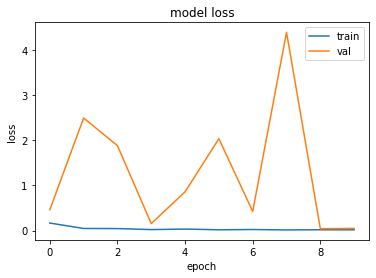

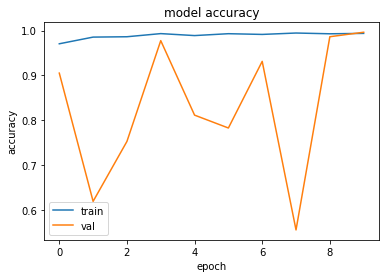

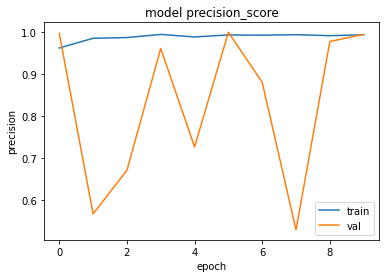

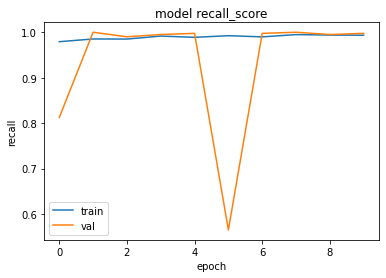

In [15]:
# Drawing the train Loss, accuracy, precision, recall of the model - visualising

smodel.plot_loss_per_epoch()
smodel.plot_accuracy_per_epoch()
smodel.plot_precision_per_epoch()
smodel.plot_recall_per_epoch()

In [16]:
# saving model to file

smodel.write_model_with_weights_to_file('smodel1.h5')